In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/deepspeech


In [2]:
import os

import numpy as np
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd
import wandb

from deepspeech import model, train, datasets, utils

/Users/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Have a look at what's going into the edge of the forward pass. Straight from the data loader:

In [3]:
def show(batches, ds, idx, cfg):
    x, nx, y, ny = batches[idx]
    xin, sr, yin = ds.dataset.ds[ds.indices[idx]]
    show_instance(x.squeeze(0), xin.squeeze(0), y[0], yin, cfg, ds)
    
def show_instance(x, xin, y, yin, cfg, ds):
    ipd.display(ipd.Audio(xin, rate=cfg.sampling_rate))
    print(yin, utils.decode_text(y, cfg))
    plt.figure(0, figsize=(20, 20))
    plt.imshow(x)
    plt.plot()
    plt.figure(2, figsize=(8, 8))
    plt.hist(x)
    plt.plot()
    
def batches(ds, p, batch_size=1):
    return list(
        torch.utils.data.dataloader.DataLoader(
            ds,
            shuffle=False,
            batch_size=batch_size,
            num_workers=0,
            collate_fn=datasets.batch(p)
        )
    )

# Samples

Let's pick out a few instances, plot them, and look at the internal distributions:

In [4]:
p = model.HParams(n_mels=20, sampling_rate=8000)
trainset, testset = datasets.splits(datasets.YesNo(p), p)

/Users/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)


[0, 1, 1, 0, 0, 1, 1, 0] lor ken ken lor lor ken ken lor


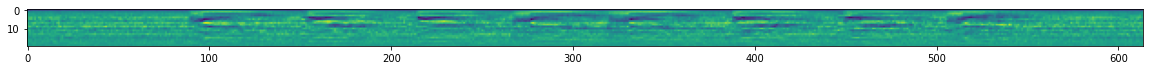

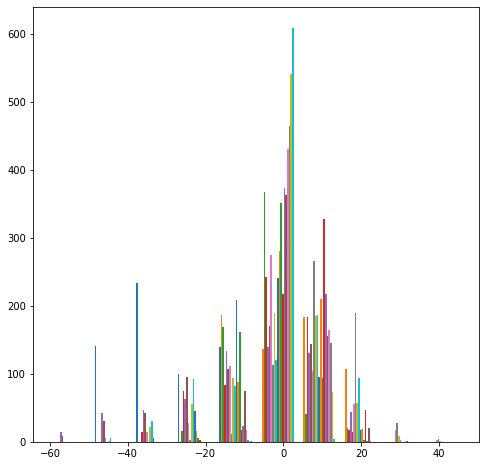

In [5]:
show(batches(trainset, p), trainset, 0, p)

[1, 1, 1, 0, 0, 0, 0, 1] ken ken ken lor lor lor lor ken


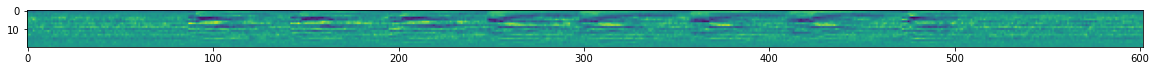

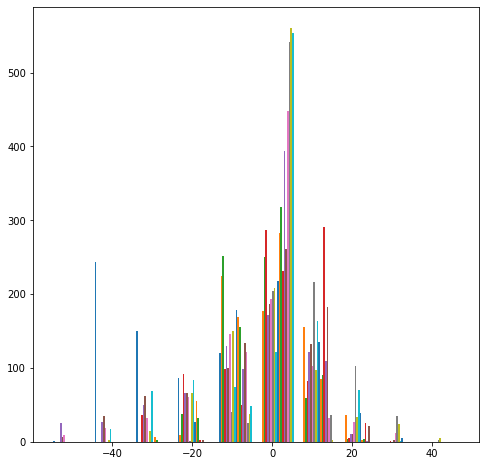

In [17]:
show(batches(trainset, p), trainset, 31, p)

[0, 0, 1, 0, 1, 0, 0, 1] lor lor ken lor ken lor lor ken


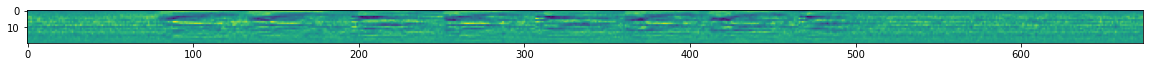

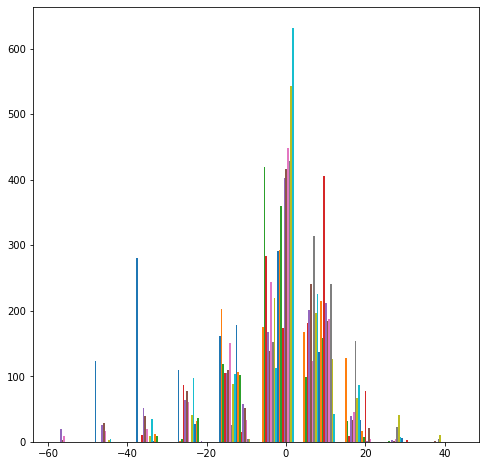

In [7]:
show(batches(testset, p), testset, 0, p)

[0, 0, 1, 1, 1, 1, 0, 0] lor lor ken ken ken ken lor lor


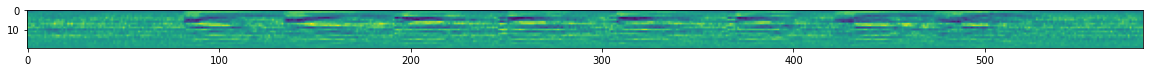

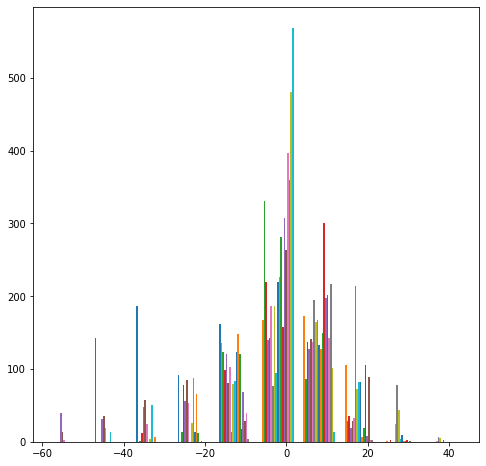

In [8]:
show(batches(testset, p), testset, 1, p)

# Global YesNo Stats

In [9]:
x, xn, y, yn = batches(datasets.YesNo(p), p, batch_size=100)[0]

<BarContainer object of 134 artists>

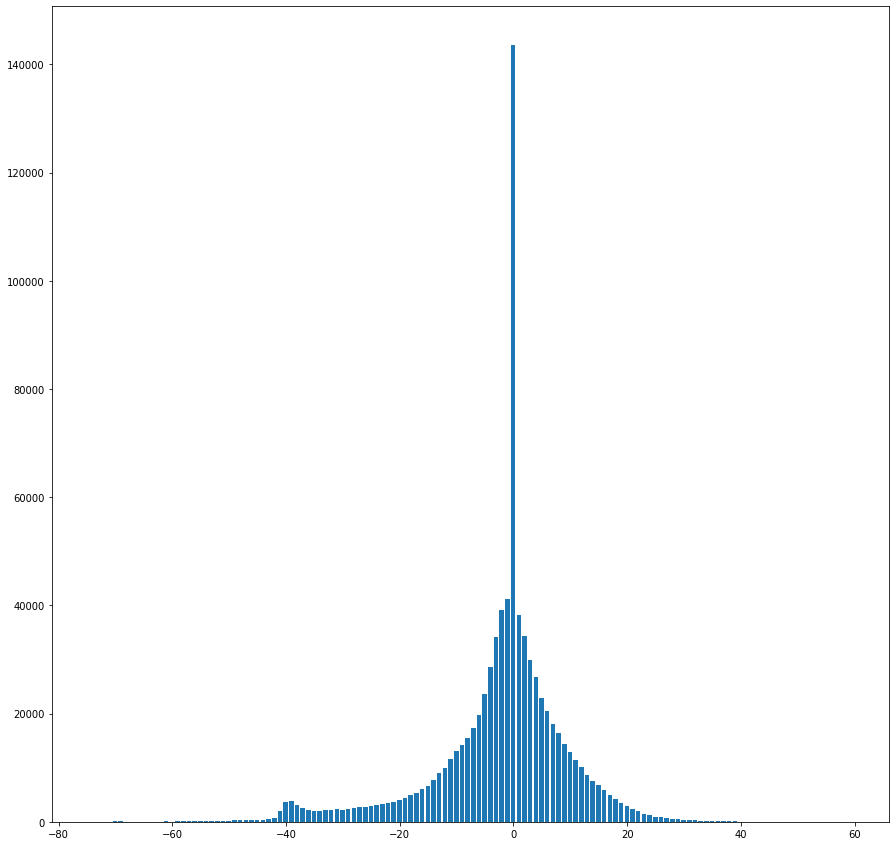

In [10]:
ticks = torch.arange(torch.min(x), torch.max(x), 1)
hist = torch.histc(x, bins=len(ticks))
plt.figure(0, figsize=(15, 15))
plt.bar(ticks, hist)

## Collation

In [11]:
batch_size = 5
batch = [trainset[i] for i in range(batch_size)]
x, nx, y, ny = datasets.batch(p)(batch)
nx_dowsampled = p.frame_lengths(nx)

In [12]:
nx, ny

(tensor([614, 612, 605, 628, 570]), tensor([31, 31, 31, 31, 31]))

In [13]:
y

tensor([[12, 15, 18, 27, 11,  5, 14, 27, 11,  5, 14, 27, 12, 15, 18, 27, 12, 15,
         18, 27, 11,  5, 14, 27, 11,  5, 14, 27, 12, 15, 18],
        [11,  5, 14, 27, 11,  5, 14, 27, 12, 15, 18, 27, 12, 15, 18, 27, 11,  5,
         14, 27, 12, 15, 18, 27, 11,  5, 14, 27, 11,  5, 14],
        [12, 15, 18, 27, 12, 15, 18, 27, 11,  5, 14, 27, 12, 15, 18, 27, 12, 15,
         18, 27, 12, 15, 18, 27, 11,  5, 14, 27, 12, 15, 18],
        [12, 15, 18, 27, 12, 15, 18, 27, 11,  5, 14, 27, 12, 15, 18, 27, 12, 15,
         18, 27, 11,  5, 14, 27, 11,  5, 14, 27, 11,  5, 14],
        [11,  5, 14, 27, 11,  5, 14, 27, 12, 15, 18, 27, 12, 15, 18, 27, 11,  5,
         14, 27, 12, 15, 18, 27, 11,  5, 14, 27, 12, 15, 18]])

In [14]:
for i in range(batch_size):
    print('want: ', trainset[i][1])
    print('gots: ', ''.join([p.graphemes[int(c)] for c in y[i]]))
    print()

want:  lor ken ken lor lor ken ken lor
gots:  lor ken ken lor lor ken ken lor

want:  ken ken lor lor ken lor ken ken
gots:  ken ken lor lor ken lor ken ken

want:  lor lor ken lor lor lor ken lor
gots:  lor lor ken lor lor lor ken lor

want:  lor lor ken lor lor ken ken ken
gots:  lor lor ken lor lor ken ken ken

want:  ken ken lor lor ken lor ken lor
gots:  ken ken lor lor ken lor ken lor



In [15]:
for i in range(batch_size):
    print('mfcc: ', trainset[i][0].shape)
    print('audio: ', trainset.dataset.ds[i][0].shape)
    print('batch: ', x[i].shape)
    print('nx: ', nx[i])
    print('nx_dowsampled: ', nx_dowsampled[i])
    print('ny: ', ny[i])
    print()

mfcc:  torch.Size([20, 614])
audio:  torch.Size([1, 50800])
batch:  torch.Size([20, 628])
nx:  tensor(614)
nx_dowsampled:  tensor(307)
ny:  tensor(31)

mfcc:  torch.Size([20, 612])
audio:  torch.Size([1, 54080])
batch:  torch.Size([20, 628])
nx:  tensor(612)
nx_dowsampled:  tensor(306)
ny:  tensor(31)

mfcc:  torch.Size([20, 605])
audio:  torch.Size([1, 48880])
batch:  torch.Size([20, 628])
nx:  tensor(605)
nx_dowsampled:  tensor(303)
ny:  tensor(31)

mfcc:  torch.Size([20, 628])
audio:  torch.Size([1, 48560])
batch:  torch.Size([20, 628])
nx:  tensor(628)
nx_dowsampled:  tensor(314)
ny:  tensor(31)

mfcc:  torch.Size([20, 570])
audio:  torch.Size([1, 48160])
batch:  torch.Size([20, 628])
nx:  tensor(570)
nx_dowsampled:  tensor(285)
ny:  tensor(31)



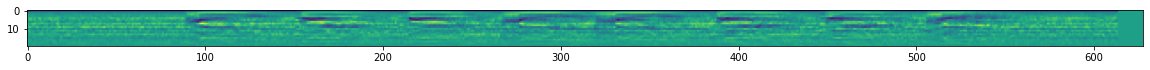

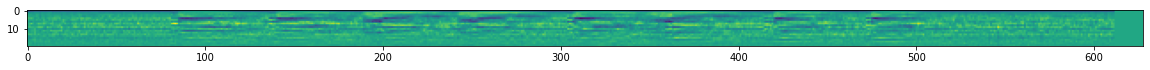

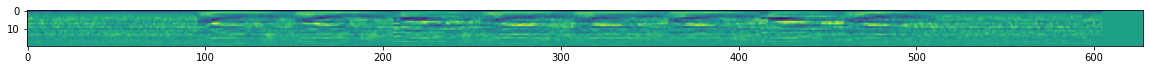

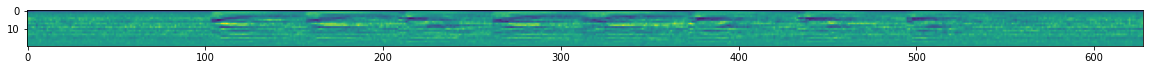

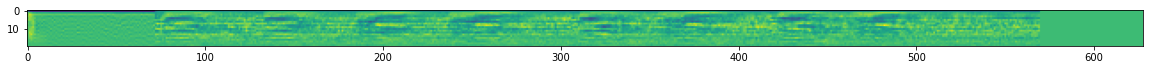

In [16]:
for i in range(batch_size):
    plt.figure(figsize=(20, 20))
    plt.imshow(x[i].detach().numpy())